In [1]:
import sqlalchemy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import qstools as qs
import math

import warnings
warnings.simplefilter('ignore')

Alternative: C:\ProgramData\Anaconda3\lib\site-packages\qstools\__init__.py win32


In [2]:
dbi = qs.interfaces.DbIndicatorsInterface(username="rsueppel", 
                                          host="qs-db.cpdsgdta9z0z.eu-west-2.rds.amazonaws.com",
                                          password="l3oT7^WerjY#O!9EGqvL", 
                                          database="qs_jpm_point_time")
cids = ['AUD', 'BRL', 'CAD', 'CHF', 'CLP', 'CNY', 'COP', 'EUR', 'GBP', 'HUF', 'IDR', 'INR', 'JPY', 
        'KRW', 'MYR', 'MXN', 'NOK', 'NZD', 'PEN', 'PHP', 'PLN', 'RON', 'RUB', 'SEK', 'SGD', 'THB', 
        'TRY', 'TWD', 'USD', 'ZAR']
cats = ['RGDP']
dfq = dbi.get_series_values(category=cats, cross_section=cids, frequency="q")

In [3]:
dfq.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 469637 entries, 0 to 469636
Data columns (total 8 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   cross_section     469637 non-null  object 
 1   category_code     469637 non-null  object 
 2   adjustment        469637 non-null  object 
 3   transformation    0 non-null       object 
 4   release_date      469637 non-null  object 
 5   observation_date  469637 non-null  object 
 6   value             469637 non-null  float64
 7   grading           469637 non-null  object 
dtypes: float64(1), object(7)
memory usage: 28.7+ MB


In [4]:
dfq['xcat'] = dfq['category_code'] + '_' + dfq['adjustment']
dfq['xcat'].unique()

array(['RGDP_SA', 'RGDP_NSA'], dtype=object)

In [5]:
dfq['ticker'] = dfq['cross_section'] + '_' + dfq['xcat']
np.sort(dfq['ticker'].unique())

array(['AUD_RGDP_SA', 'BRL_RGDP_SA', 'CAD_RGDP_SA', 'CHF_RGDP_SA',
       'CLP_RGDP_SA', 'CNY_RGDP_NSA', 'COP_RGDP_SA', 'EUR_RGDP_SA',
       'GBP_RGDP_SA', 'HUF_RGDP_SA', 'IDR_RGDP_NSA', 'JPY_RGDP_SA',
       'KRW_RGDP_SA', 'MXN_RGDP_SA', 'NOK_RGDP_SA', 'NZD_RGDP_SA',
       'PEN_RGDP_NSA', 'PHP_RGDP_NSA', 'RON_RGDP_SA', 'RUB_RGDP_NSA',
       'SEK_RGDP_SA', 'SGD_RGDP_SA', 'THB_RGDP_SA', 'TRY_RGDP_NSA',
       'TWD_RGDP_SA', 'USD_RGDP_SA', 'ZAR_RGDP_SA'], dtype=object)

## Data availability

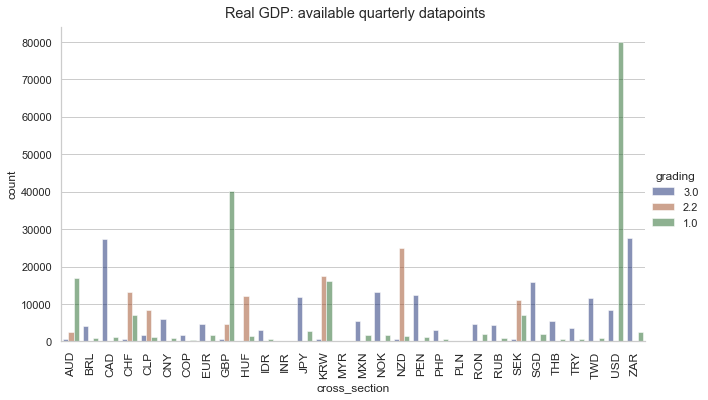

In [6]:
sns.set_theme(style='whitegrid')
g = sns.catplot(data=dfq, kind='count', order=cids, x='cross_section', hue='grading',
                palette='dark', aspect=1.8, alpha=0.5)
g.set_xticklabels(rotation=90, size=12)
g.fig.suptitle('Real GDP: available quarterly datapoints', y=1.02)
plt.show()

In [7]:
def countmap(cat, start_year, figsize=(12, 12), trueVin = False):
    dfx = dfq[dfq['category_code']==cat]
    if trueVin:
        dfx = dfx[dfx['grading'].isin(['1', '1.0', '2.2'])]
    xids = np.sort(dfx['cross_section'].unique())
    dfx.loc[:, 'year'] = pd.DatetimeIndex(dfx.loc[:,'release_date']).year
    dfx = dfx[dfx.year >= start_year]

    dfxx = pd.DataFrame(columns=dfx.columns)
    for cid in xids:
        dfc = dfx.query('cross_section == @cid').reset_index(drop=True)
        releases = dfc[["year", "release_date"]].groupby("year")["release_date"].max().values.tolist()  # use panda series!
        dfcx = dfc[dfc['release_date'].isin(releases)]
        dfxx = dfxx.append(dfcx)

    count_matrix = pd.crosstab(dfxx["year"], dfxx["cross_section"])  # per default crosstab counts rows
    fig, ax = plt.subplots(figsize=figsize)
    sns.heatmap(count_matrix, annot=True, fmt="d",
                    cmap="YlGnBu", cbar=False, linewidths=.5)
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_title(cat + ': Vintage lengths at last available release in year', y = 1.1, fontsize=14)

<function matplotlib.pyplot.show(*args, **kw)>

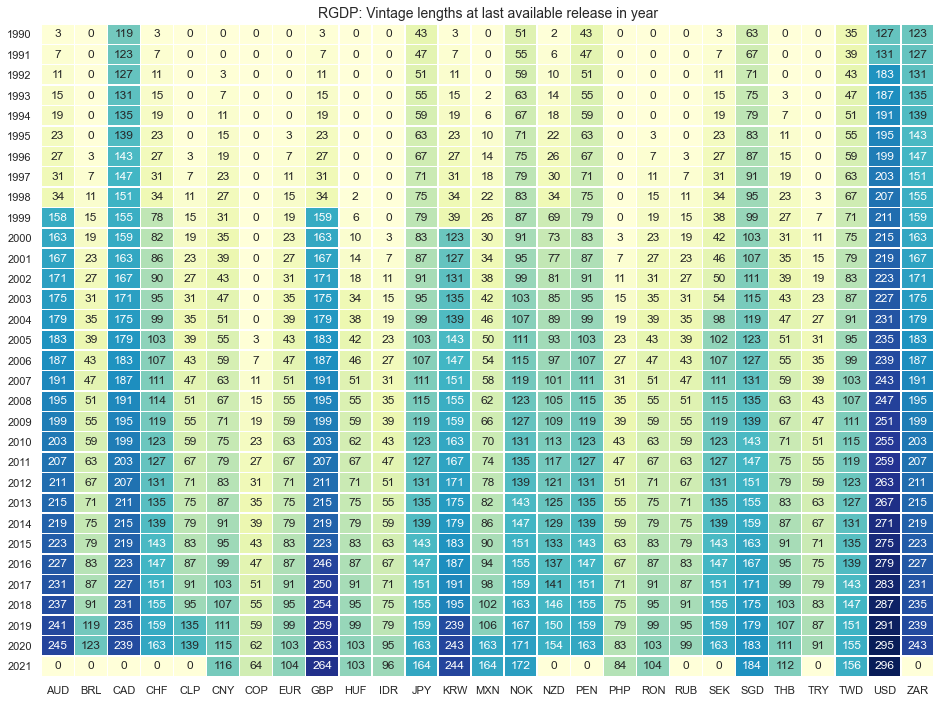

In [8]:
countmap('RGDP', 1990, (16, 12))
plt.show

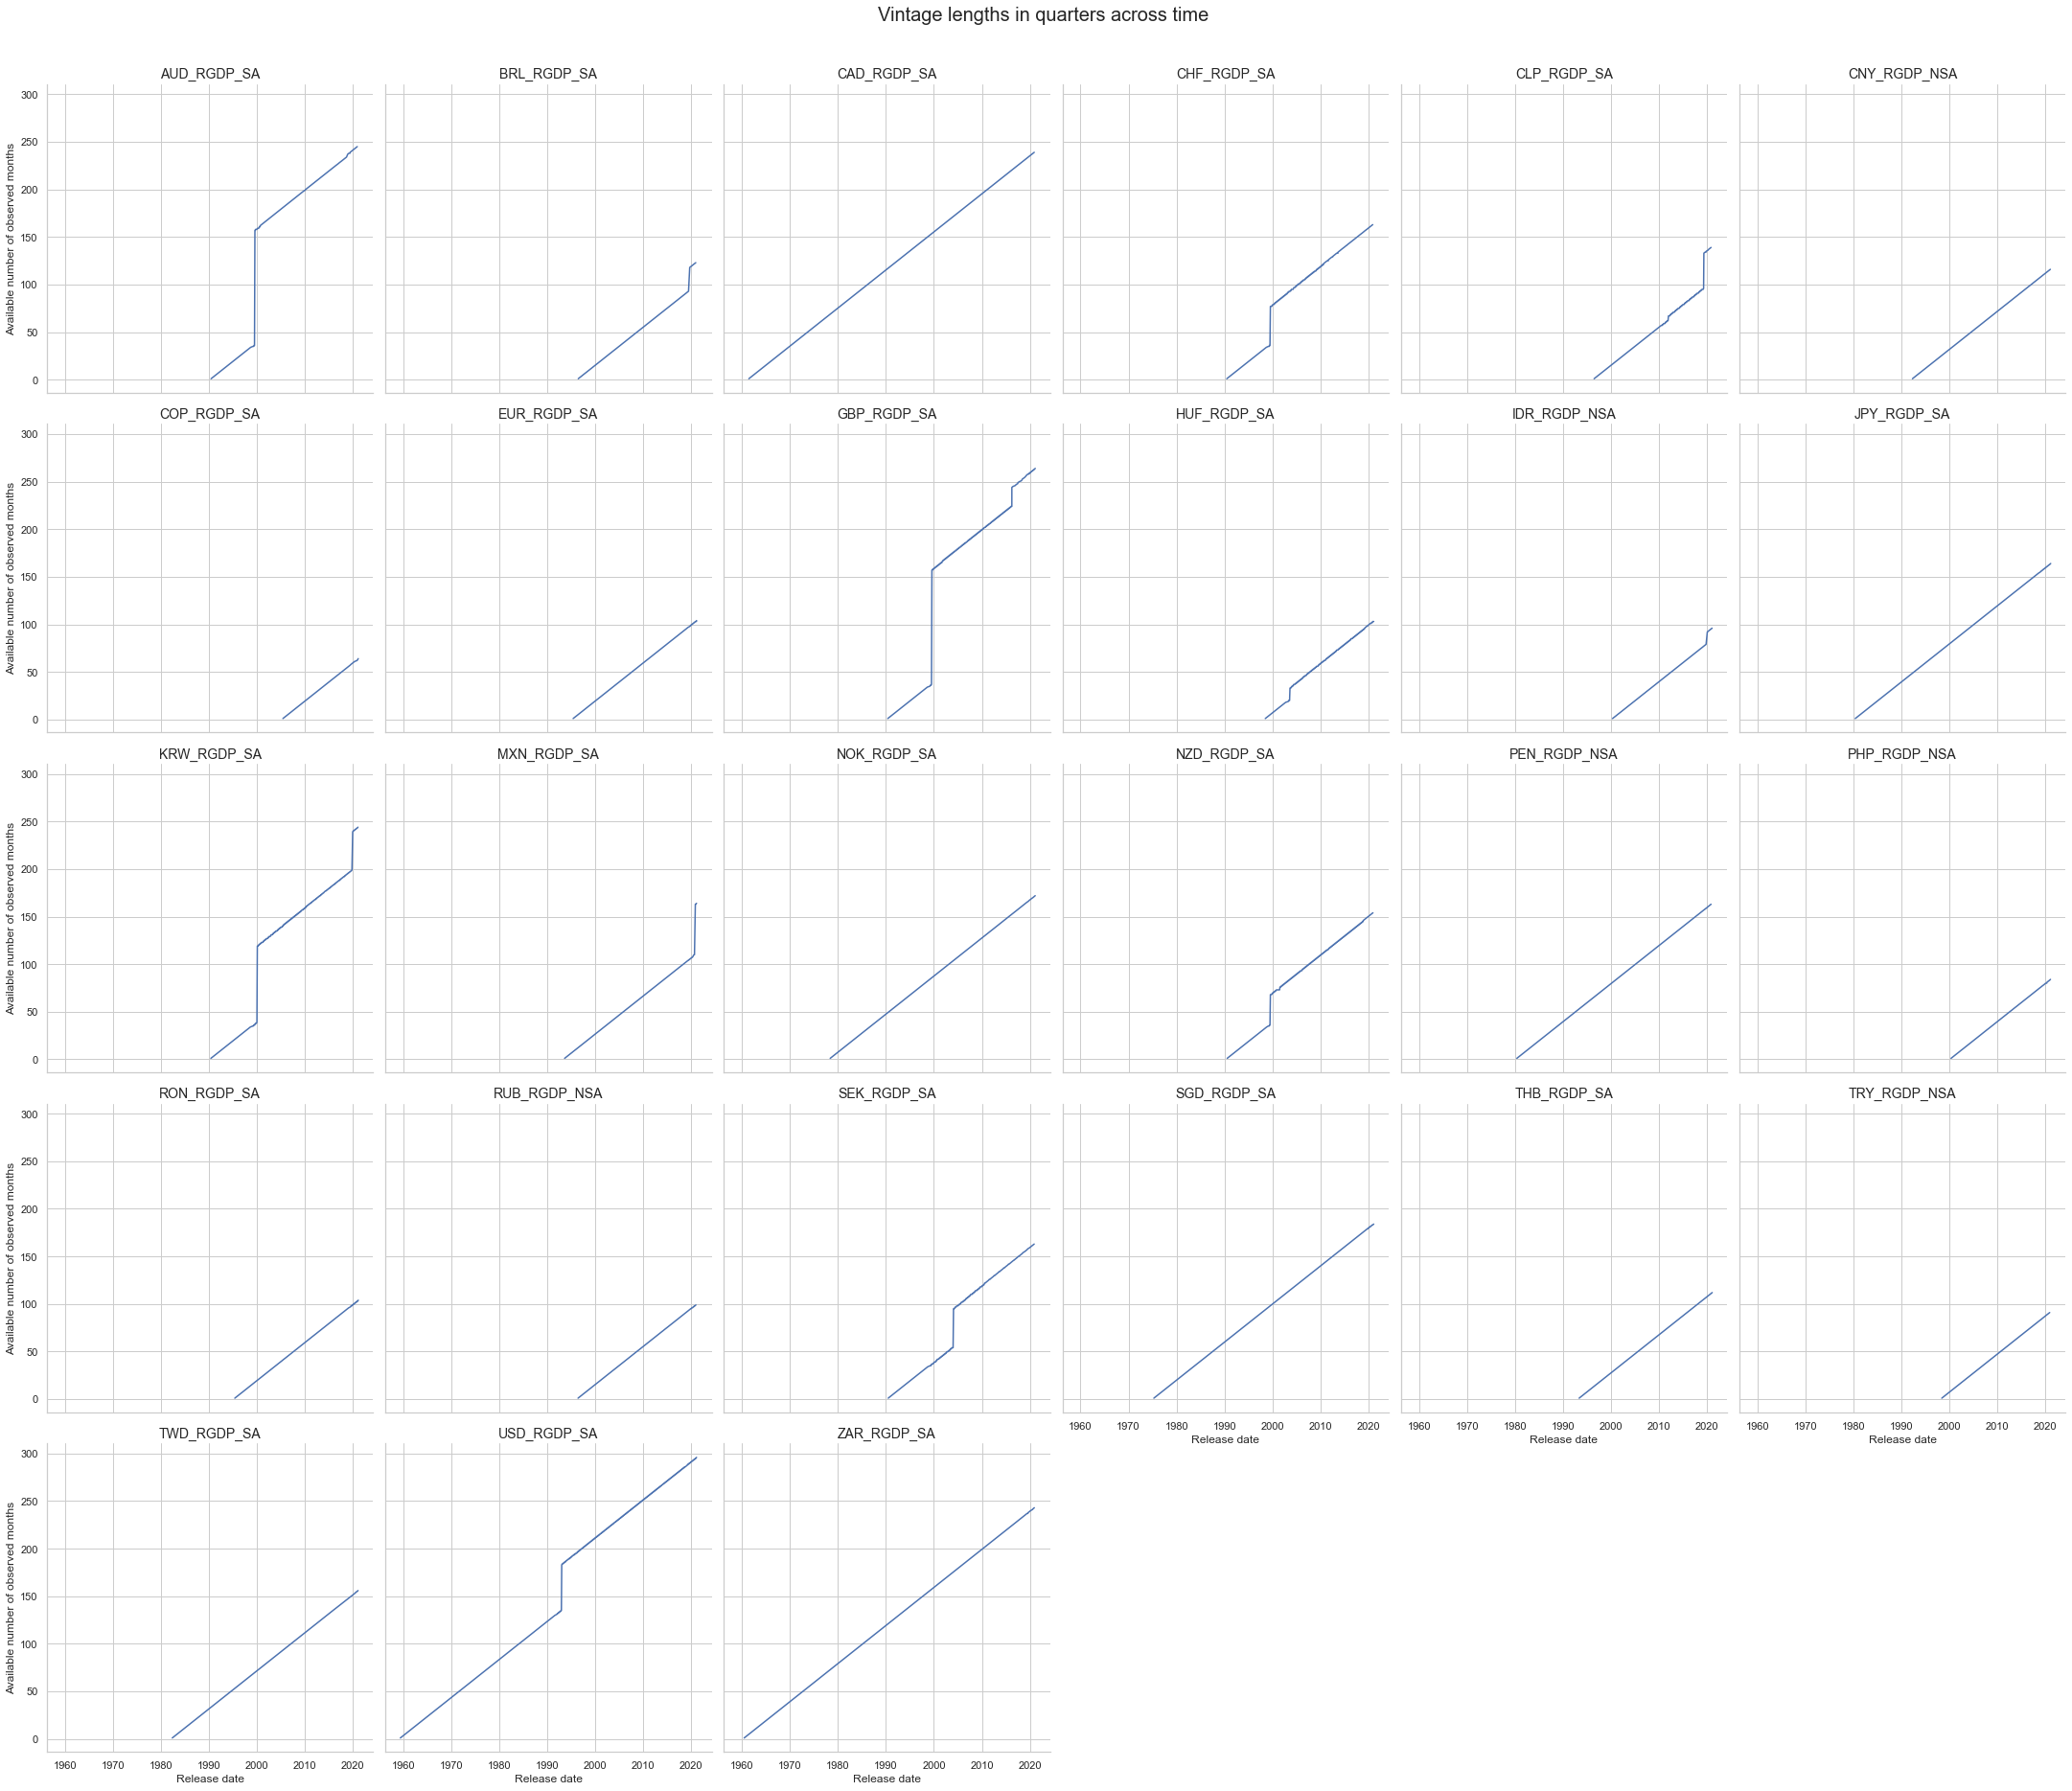

In [9]:
cols = ['ticker', 'release_date', 'observation_date']
dfq_x = dfq.loc[:, cols].groupby(['ticker', 'release_date']).agg('count')
dfq_x.reset_index(inplace=True)
f = sns.relplot(x='release_date', y = 'observation_date', data=dfq_x, kind='line', col='ticker', col_wrap=6)
(f.set_axis_labels("Release date", "Available number of observed months")
  .set_titles("{col_name}", size=14)
  .fig.suptitle('Vintage lengths in quarters across time', y = 1.03, fontsize=20))
plt.show()

## Revision graphics

In [10]:
def revlines_qpoya(df, pots, ncols=4, size = (16, 16)):
    
    ticks = np.sort(df['ticker'].unique())
    
    sns.set_style('whitegrid')
    colors = sns.color_palette("Blues", len(pots))
    fig, axes = plt.subplots(nrows=math.ceil(len(ticks)/ncols), ncols=ncols, sharex=True, figsize=size)

    for i in range(len(ticks)):
        tick = ticks[i]
        dfc = df.query('ticker == @tick')
        releases = dfc['release_date'].unique()
        for p in range(len(pots)):  # get releases nearest and before chosen ones
            release = releases[(releases <= pd.to_datetime(pots[p]))].max()
            dfcx_add = dfc[dfc['release_date'].isin([release])]
            dfcx_add['value'] = 100* dfcx_add['value'].pct_change(4)
            dfcx = dfcx_add if (p == 0) else dfcx.append(dfcx_add) 
        axe = axes[math.floor(i / ncols), (i % ncols)]
        sns.lineplot(data=dfcx,  x="observation_date", y="value", 
                     hue="release_date", palette=colors, ax=axe)
        axe.set(title=tick, ylabel="", xlabel="")

    plt.show()

<function matplotlib.pyplot.show(*args, **kw)>

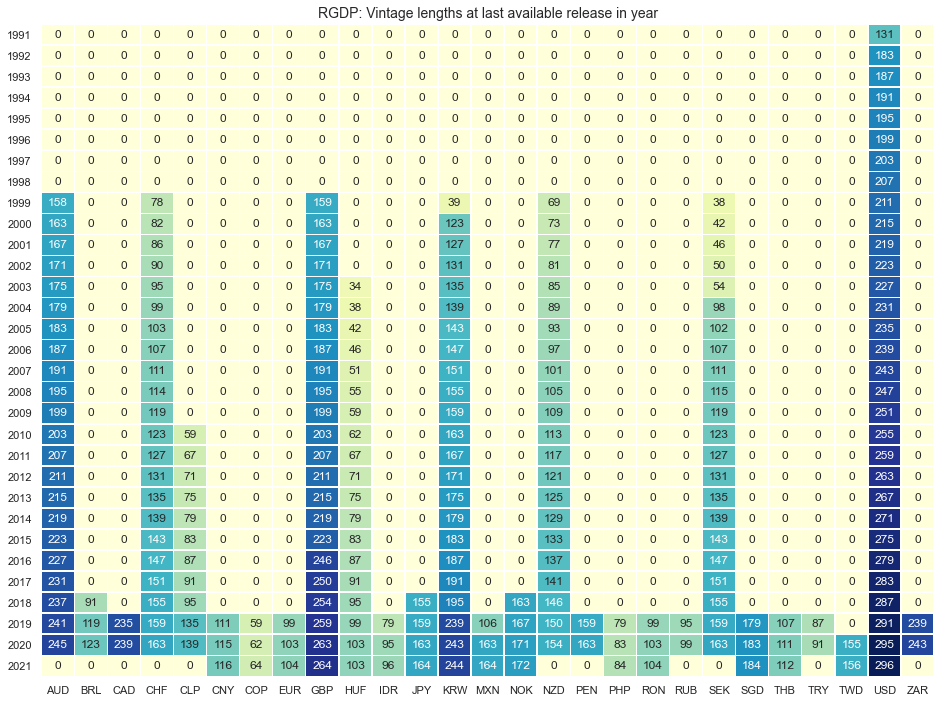

In [11]:
countmap('RGDP', 1990, (16, 12), trueVin=True)
plt.show

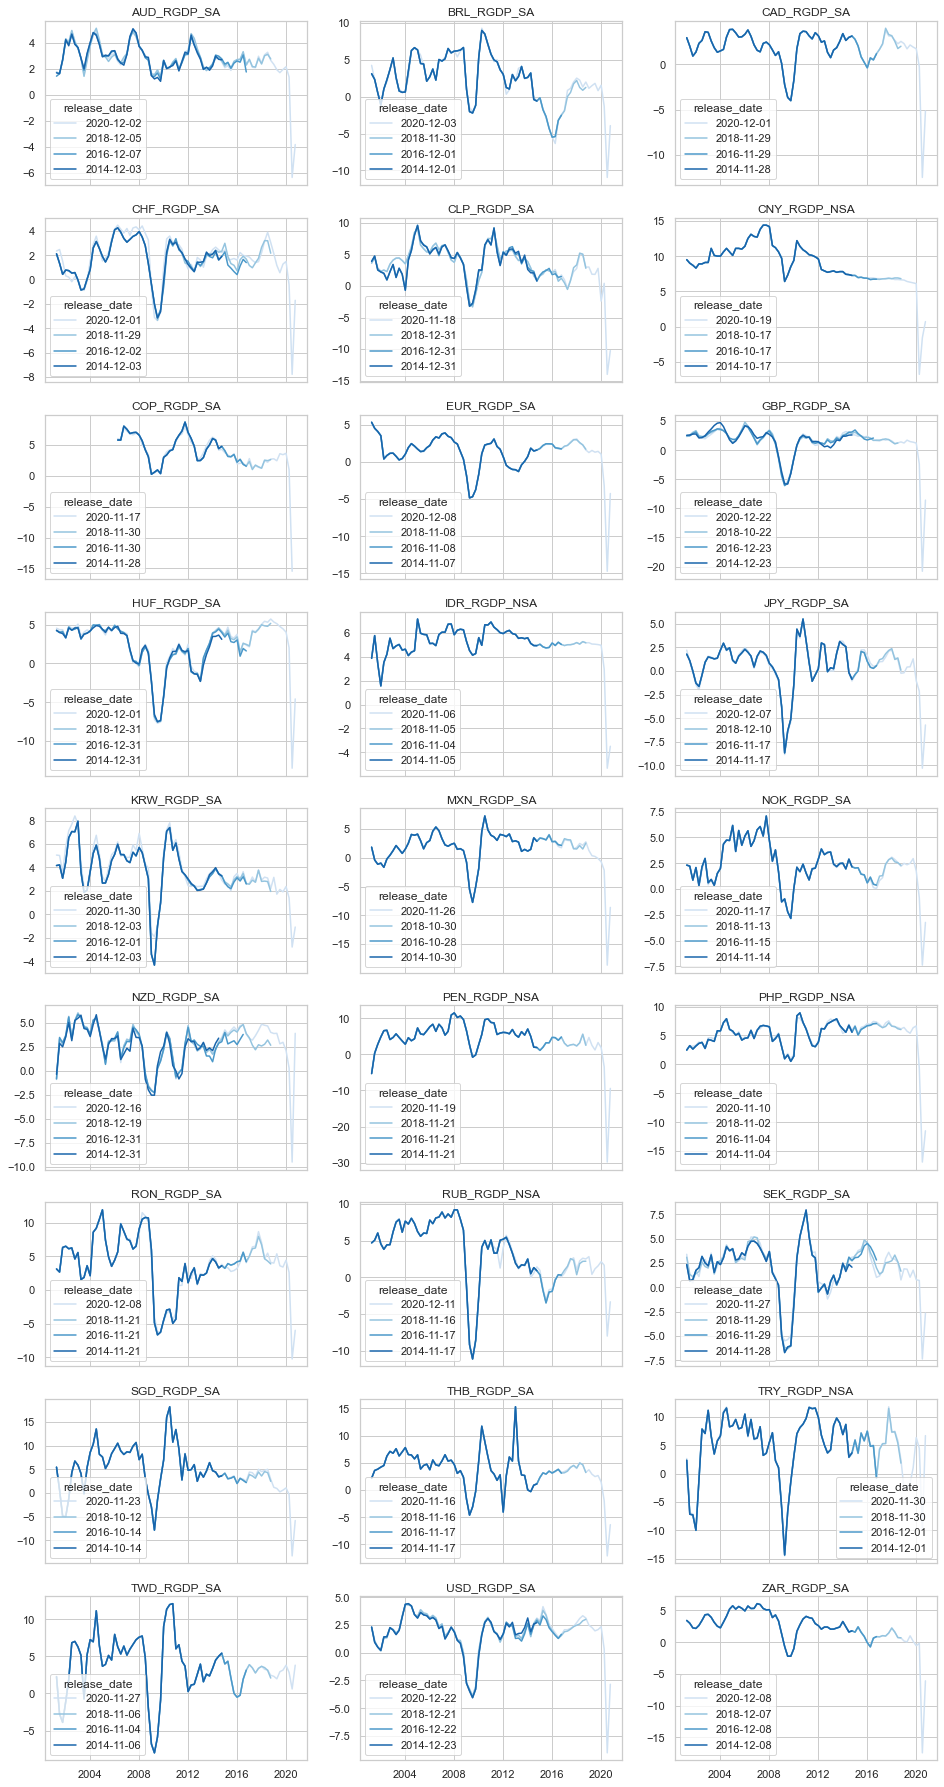

In [12]:
pots = ['2020-12-31', '2018-12-31', '2016-12-31', '2014-12-31']
dfq_x = dfq[dfq['observation_date'] > pd.to_datetime('2000-01-01')] 

revlines_qpoya(dfq_x, pots=pots, ncols=3, size = (16, 32))

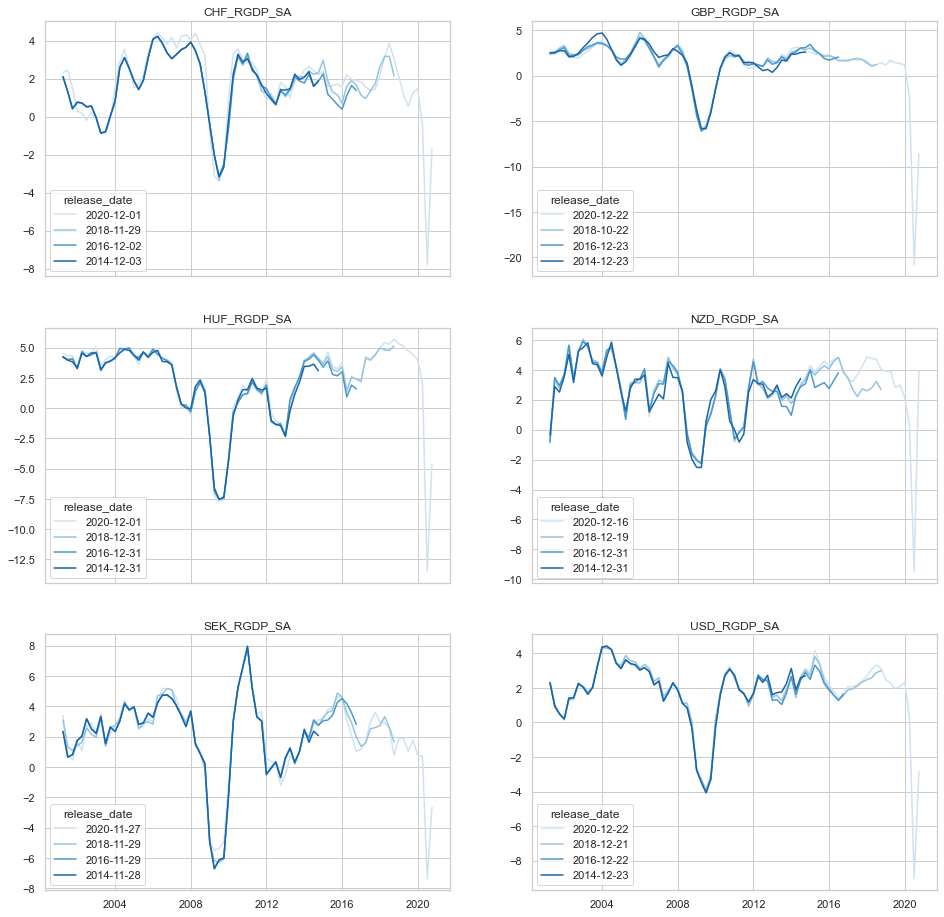

In [13]:
pots = ['2020-12-31', '2018-12-31', '2016-12-31', '2014-12-31']
filt1 = dfq['observation_date'] > pd.to_datetime('2000-01-01')
filt2 = dfq['cross_section'].isin(['CHF', 'GBP', 'HUF', 'NZD', 'SEK', 'USD'])
dfq_x = dfq[filt1 & filt2] 

revlines_qpoya(dfq_x, pots=pots, ncols=2, size = (16, 16))

## Glance at latest vintages since 2000

In [14]:
indices = []
for tick in dfq.ticker.unique():  # extract dataframe with last release_dates for each ticker only
    dfq_x = dfq[dfq['ticker'] == tick]
    dfq_xx = dfq_x[dfq_x['release_date'] == dfq_x['release_date'].max()]
    indices = indices + dfq_xx.index.tolist()
dfq_lv = dfq.iloc[indices, :]  # extract last vintage

In [15]:
dfq_lvw = dfq_lv.pivot(index='observation_date', columns='ticker', values='value')  # wide dataframe with ticker columns
dfq_lvw = dfq_lvw[dfq_lvw.index >= pd.to_datetime('1999-01-01')]
dfq_lvw_p = dfq_lvw.pct_change(periods=4) * 100
dfq_lvp = dfq_lvw_p.stack().reset_index().sort_values(['ticker', 'observation_date'])  # stack df of percent values
dfq_lvp = dfq_lvp.rename(columns={0: 'value'}).reset_index(drop=True)
dfq_lvp[['cross_section', 'xcat']] = dfq_lvp['ticker'].str.split('_', 1, expand=True)  # split string column

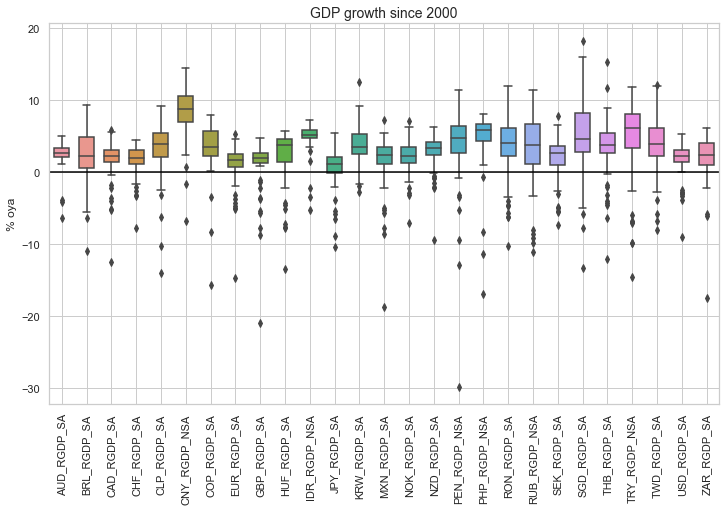

In [16]:
sns.set(style="whitegrid", palette="Paired", rc={'figure.figsize':(12, 7)})  # set axis plot size
sns.despine(offset=10, trim=False)

ax = sns.boxplot(data=dfq_lvp, y="value", x="ticker", width=0.6)
ax.set(xlabel='', ylabel='% oya')
ax.set_title('GDP growth since 2000', y = 1, fontsize=14)
ax.xaxis.grid(True) # Show the vertical gridlines
ax.axhline(0, ls='-', c='black')

plt.setp(ax.get_xticklabels(), rotation=90)
plt.show()